# Imports

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import xgboost as xgb
import warnings
warnings.simplefilter("ignore", UserWarning)
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.express as px

# Read the dataframe

In [2]:
file_path = r"C:\Users\karth\Downloads\operational_demand.csv"
df = pd.read_csv(file_path)

# Data Cleaning & Manipulation

In [3]:
df = df.drop(['awbiMetadataKeyHash', 'awbiMetadataChangeHash','awbiMetadataCreateDateTime',
                                'awbiMetadataLoadYear','awbiMetadataLoadMonth','awbiMetadataLoadDay',
                                'awbiMetadataLoadHour','awbiMetadataLoadDateTime'], axis=1)
df = df.reset_index(drop=True)

In [4]:
unique_value = df['operationalDemandWorkCentreGroup'].nunique()
print("Unique values in operationalDemandWorkCentreGroup: ", unique_value)

value_counts = df['operationalDemandWorkCentreGroup'].value_counts()
print("Value counts in operationalDemandWorkCentreGroup: ", value_counts)

Unique values in operationalDemandWorkCentreGroup:  1
Value counts in operationalDemandWorkCentreGroup:  operationalDemandWorkCentreGroup
493    6035
Name: count, dtype: int64


In [5]:
df.dtypes

operationalDemandDate                  object
operationalDemandOrderTypeGroup        object
operationalDemandProcess               object
operationalDemandWorkCentreGroup        int64
operationalDemandOpHoursCount           int64
operationalDemandOpHoursSum           float64
operationalDemandDateSid                int64
operationalDemandDateWeekBeginDate     object
operationalDemandSumZeroedRe          float64
operationalDemandOpTravelHours        float64
dtype: object

In [6]:
# Changing the operationalDemandDate column to a date time format allowing us to grab features from the date when required
df['operationalDemandDate'] = pd.to_datetime(df['operationalDemandDate'])

#Changing the columns below to a string/flot data type respecriveely to allow for data manipulation
df['operationalDemandWorkCentreGroup'] = df['operationalDemandWorkCentreGroup'].astype(str)
df['operationalDemandDateSid'] = df['operationalDemandDateSid'].astype(str)
df['operationalDemandOpTravelHours'] = df['operationalDemandOpTravelHours'].astype(float)

In [7]:
#Sorting the dates in an ascending order
df = df.sort_values(by=['operationalDemandDateWeekBeginDate','operationalDemandDate'], ascending= True)

In [8]:
# Making use of the dt.year/month etc repectively to create a new column in the dataset which stores only the year/month of the operationalDemandDate
df['OperationalDemandYear'] = df['operationalDemandDate'].dt.year
df['OperationalDemandMonth'] = df['operationalDemandDate'].dt.month
df['OperationalDemandDayofweek'] = df['operationalDemandDate'].dt.day_of_week
df['OperationalDemandQuarter'] = df['operationalDemandDate'].dt.quarter
df

,operationalDemandDate,operationalDemandOrderTypeGroup,operationalDemandProcess,operationalDemandWorkCentreGroup,operationalDemandOpHoursCount,operationalDemandOpHoursSum,operationalDemandDateSid,operationalDemandDateWeekBeginDate,operationalDemandSumZeroedRe,operationalDemandOpTravelHours,OperationalDemandYear,OperationalDemandMonth,OperationalDemandDayofweek,OperationalDemandQuarter
1158,2019-04-01,PLANNED,COLLECTION,493,140,83.700000,20190401,2019-04-01T00:00:00.000+0000,47.266667,54.224462,2019,4,0,2
4735,2019-04-01,PLANNED,TREATMENT,493,30,80.800000,20190401,2019-04-01T00:00:00.000+0000,47.666667,13.086870,2019,4,0,2
5039,2019-04-01,REACTIVE,MAINTENANCE,493,39,87.066667,20190401,2019-04-01T00:00:00.000+0000,59.500000,21.249216,2019,4,0,2
2338,2019-04-02,PLANNED,COLLECTION,493,1,0.500000,20190402,2019-04-01T00:00:00.000+0000,0.416667,0.238611,2019,4,1,2
3217,2019-04-02,REACTIVE,COLLECTION,493,20,38.233333,20190402,2019-04-01T00:00:00.000+0000,26.333333,8.394569,2019,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3400,2024-01-29,PLANNED,COLLECTION,493,1,2.000000,20240129,2024-01-29T00:00:00.000+0000,0.000000,0.587613,2024,1,0,1
6028,2024-01-29,PLANNED,MAINTENANCE,493,129,118.083333,20240129,2024-01-29T00:00:00.000+0000,0.000000,67.171177,2024,1,0,1
254,2024-02-01,PLANNED,COLLECTION,493,120,86.883333,20240201,2024-01-29T00:00:00.000+0000,0.000000,70.513571,2024,2,3,1
5305,2024-02-01,PLANNED,MAINTENANCE,493,11,11.000000,20240201,2024-01-29T00:00:00.000+0000,0.000000,5.727775,2024,2,3,1


- **For OperationalDemandDayofweek**
- Monday = 0
- Tuesday = 1
- Wednesday = 2
- Thursday = 3
- Friday = 4
- Saturday = 5
- Sunday = 6

In [9]:
#Looking at the minimum date from when the forecasting data starts
print("The minimum date from when the forecasting data starts is: ", df['operationalDemandDate'].min())

#Looking at the minimum date from when the forecasting data ends
print("The maximum date from when the forecasting data ends is: ", df['operationalDemandDate'].max())

The minimum date from when the forecasting data starts is:  2019-04-01 00:00:00
The maximum date from when the forecasting data ends is:  2024-02-04 00:00:00


# Handling the outliers

In [10]:
#USing standard anomaly detection of q1/q3 +- 1.5 * IQR to identify outliers and improve the predictability of models

#Upper and Lower Quartiles for the flow data to identify IQR
q1_hours = df['operationalDemandOpHoursSum'].quantile(0.25)
q3_hours = df['operationalDemandOpHoursSum'].quantile(0.75)

#IQR and Upper and lower bounds to catch outliers 
iqr_hours = q3_hours - q1_hours
lower_bound_hours = q1_hours - 1.5 * iqr_hours
upper_bound_hours = q3_hours + 1.5 * iqr_hours


#Filtered Data frame to apply boundaries to values for each site and for the respective feature and response variables
df = df[
    (df['operationalDemandOpHoursSum'] >= lower_bound_hours) & (df['operationalDemandOpHoursSum'] <= upper_bound_hours)]

# Differntiating Weekday/Weekened

In [11]:
# Filtering a weekday df to only contain days from mon - fri
weekday_df = df[df['OperationalDemandDayofweek'].isin([0, 1, 2, 3, 4])]
weekday_df['OperationalDemandDayofweek'].unique()

array([0, 1, 2, 3, 4])

# Weekened Manipulation 

In [12]:
# Weeknd data set to only include sat - sun
weekend_df = df[df['OperationalDemandDayofweek'].isin([5, 6])]
weekend_df

,operationalDemandDate,operationalDemandOrderTypeGroup,operationalDemandProcess,operationalDemandWorkCentreGroup,operationalDemandOpHoursCount,operationalDemandOpHoursSum,operationalDemandDateSid,operationalDemandDateWeekBeginDate,operationalDemandSumZeroedRe,operationalDemandOpTravelHours,OperationalDemandYear,OperationalDemandMonth,OperationalDemandDayofweek,OperationalDemandQuarter
1812,2019-04-06,REACTIVE,?,493,1,0.416667,20190406,2019-04-01T00:00:00.000+0000,1.416667,0.596775,2019,4,5,2
4362,2019-04-06,REACTIVE,TREATMENT,493,9,10.333333,20190406,2019-04-01T00:00:00.000+0000,4.916667,2.705398,2019,4,5,2
1299,2019-04-07,REACTIVE,?,493,5,5.166667,20190407,2019-04-01T00:00:00.000+0000,6.666667,2.983873,2019,4,6,2
2297,2019-04-07,PLANNED,MAINTENANCE,493,2,5.533333,20190407,2019-04-01T00:00:00.000+0000,2.000000,2.146389,2019,4,6,2
3402,2019-04-07,REACTIVE,COLLECTION,493,15,32.516667,20190407,2019-04-01T00:00:00.000+0000,16.500000,7.100452,2019,4,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5924,2023-12-24,PLANNED,TREATMENT,493,18,9.000000,20231224,2023-12-18T00:00:00.000+0000,0.000000,17.457164,2023,12,6,4
625,2024-01-06,PLANNED,COLLECTION,493,1,1.000000,20240106,2024-01-01T00:00:00.000+0000,0.000000,0.587613,2024,1,5,1
5765,2024-01-14,PLANNED,COLLECTION,493,2,1.000000,20240114,2024-01-08T00:00:00.000+0000,0.000000,1.175226,2024,1,6,1
4363,2024-01-28,PLANNED,COLLECTION,493,1,4.000000,20240128,2024-01-22T00:00:00.000+0000,0.000000,0.587613,2024,1,6,1


In [13]:
# Weekend groupby in which we get a sum of hours for the weekend
weekend_groupby = weekend_df.groupby('operationalDemandDateWeekBeginDate')['operationalDemandOpHoursSum'].sum().reset_index()
weekend_groupby

,operationalDemandDateWeekBeginDate,operationalDemandOpHoursSum
0,2019-04-01T00:00:00.000+0000,90.816667
1,2019-04-08T00:00:00.000+0000,79.333333
2,2019-04-15T00:00:00.000+0000,113.766667
3,2019-04-22T00:00:00.000+0000,38.583333
4,2019-04-29T00:00:00.000+0000,57.300000
...,...,...
245,2023-12-18T00:00:00.000+0000,11.250000
246,2024-01-01T00:00:00.000+0000,1.000000
247,2024-01-08T00:00:00.000+0000,1.000000
248,2024-01-22T00:00:00.000+0000,4.000000


In [14]:
# Shift function to create date time features in which we can utlise previous weeks data as covariates to predict workload 
def shift_function(df,new_column_name,shift):
  df[new_column_name] = df['operationalDemandOpHoursSum'].shift(shift)
  
# Shift function to create previous week's features for the weekend 
shift_1_weekend = shift_function(weekend_groupby, 'prev_week_1', 1)
shift_2_weekend = shift_function(weekend_groupby, 'prev_week_2', 2)
shift_3_weekend = shift_function(weekend_groupby, 'prev_week_3', 3)
shift_4_weekend = shift_function(weekend_groupby, 'prev_week_4', 4)

In [15]:
# dropping na's as a result of the shift function
weekend_groupby = weekend_groupby.dropna(axis=0)

In [16]:
# extracting date time featuresfor covariates within the prediction

weekend_groupby['operationalDemandDateWeekBeginDate'] = pd.to_datetime(weekend_groupby['operationalDemandDateWeekBeginDate'])
weekend_groupby['OperationalDemandYear'] = weekend_groupby['operationalDemandDateWeekBeginDate'].dt.year
weekend_groupby['OperationalDemandMonth'] = weekend_groupby['operationalDemandDateWeekBeginDate'].dt.month
weekend_groupby['OperationalDemandWeek'] = weekend_groupby['operationalDemandDateWeekBeginDate'].dt.isocalendar().week

C:\Users\karth\AppData\Local\Temp\ipykernel_23568\2529061735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_groupby['operationalDemandDateWeekBeginDate'] = pd.to_datetime(weekend_groupby['operationalDemandDateWeekBeginDate'])
C:\Users\karth\AppData\Local\Temp\ipykernel_23568\2529061735.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_groupby['OperationalDemandYear'] = weekend_groupby['operationalDemandDateWeekBeginDate'].dt.year
C:\Users\karth\AppData\Local\Temp\ipykernel_23568\25290

# Weekday Manipulation

In [17]:
# grouping by the week and the operational demand sum to get a sum for the week
week_groupby = weekday_df.groupby('operationalDemandDateWeekBeginDate')['operationalDemandOpHoursSum'].sum().reset_index()

# Alligning the dates for both week and weekend to ensure both df's have the same date time frame
week_groupby = week_groupby.drop(index=236, axis=1)
week_groupby

,operationalDemandDateWeekBeginDate,operationalDemandOpHoursSum
0,2019-04-01T00:00:00.000+0000,680.300000
1,2019-04-08T00:00:00.000+0000,501.683333
2,2019-04-15T00:00:00.000+0000,583.566667
3,2019-04-22T00:00:00.000+0000,346.100000
4,2019-04-29T00:00:00.000+0000,648.450000
...,...,...
247,2024-01-01T00:00:00.000+0000,2.000000
248,2024-01-08T00:00:00.000+0000,0.500000
249,2024-01-15T00:00:00.000+0000,87.250000
250,2024-01-22T00:00:00.000+0000,5.633333


# Shift Function for Week

In [18]:


# previous week's data ranging from week 1 - 4
shift_1_week = shift_function(week_groupby, 'prev_week_1', 1)
shift_2_week = shift_function(week_groupby, 'prev_week_2', 2)
shift_3_week = shift_function(week_groupby, 'prev_week_3', 3)
shift_4_week = shift_function(week_groupby, 'prev_week_4', 4)

In [19]:
# The shift function creates na within the df in which need to be dropped
week_groupby = week_groupby.dropna(axis=0)

In [20]:
week_groupby['operationalDemandDateWeekBeginDate'] = pd.to_datetime(week_groupby['operationalDemandDateWeekBeginDate'])
week_groupby['OperationalDemandYear'] = week_groupby['operationalDemandDateWeekBeginDate'].dt.year
week_groupby['OperationalDemandMonth'] = week_groupby['operationalDemandDateWeekBeginDate'].dt.month
week_groupby['OperationalDemandWeek'] = week_groupby['operationalDemandDateWeekBeginDate'].dt.isocalendar().week

C:\Users\karth\AppData\Local\Temp\ipykernel_23568\1355344860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_groupby['operationalDemandDateWeekBeginDate'] = pd.to_datetime(week_groupby['operationalDemandDateWeekBeginDate'])
C:\Users\karth\AppData\Local\Temp\ipykernel_23568\1355344860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_groupby['OperationalDemandYear'] = week_groupby['operationalDemandDateWeekBeginDate'].dt.year
C:\Users\karth\AppData\Local\Temp\ipykernel_23568\1355344860.py:3: 

# EDA

[Text(0.5, 1.0, 'Operational demand time series plot')]

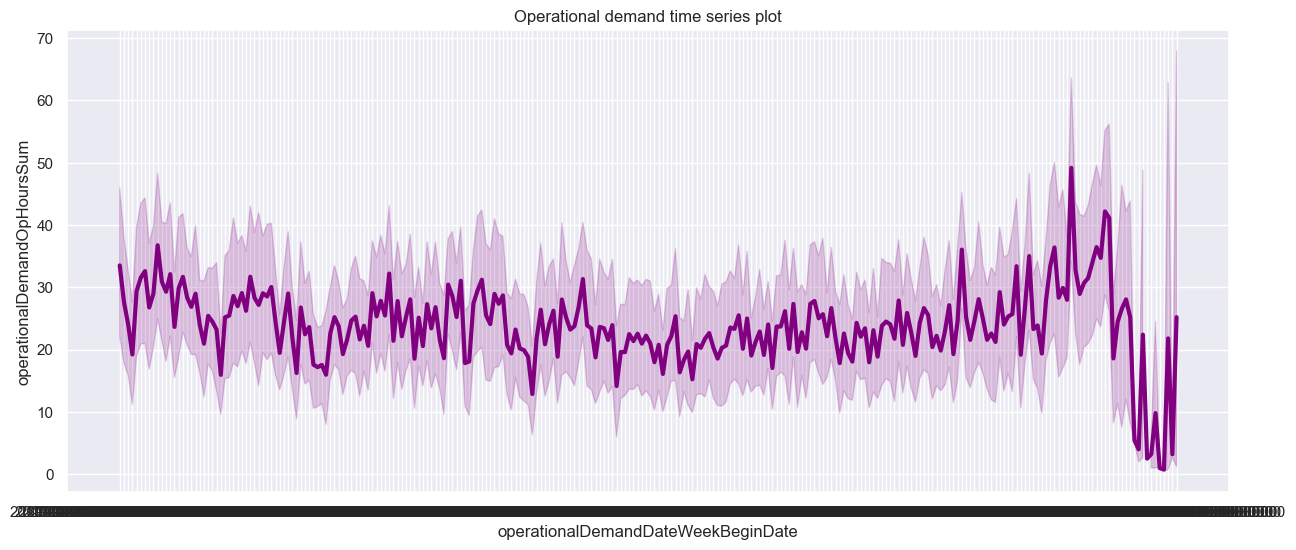

In [21]:
#time series plot for operational hours from start to end

#Week commencing on the x-axis
x = df['operationalDemandDateWeekBeginDate']

#total hours for the week
y = df['operationalDemandOpHoursSum']

#Seaborn timeseries plot

#Seaborn timeseries plot
sns.set(rc={"figure.figsize":(15, 6)})
sns.lineplot(x='operationalDemandDateWeekBeginDate', y='operationalDemandOpHoursSum', data=df, linewidth=3, color='purple',
             linestyle='solid').set(title='Operational demand time series plot')

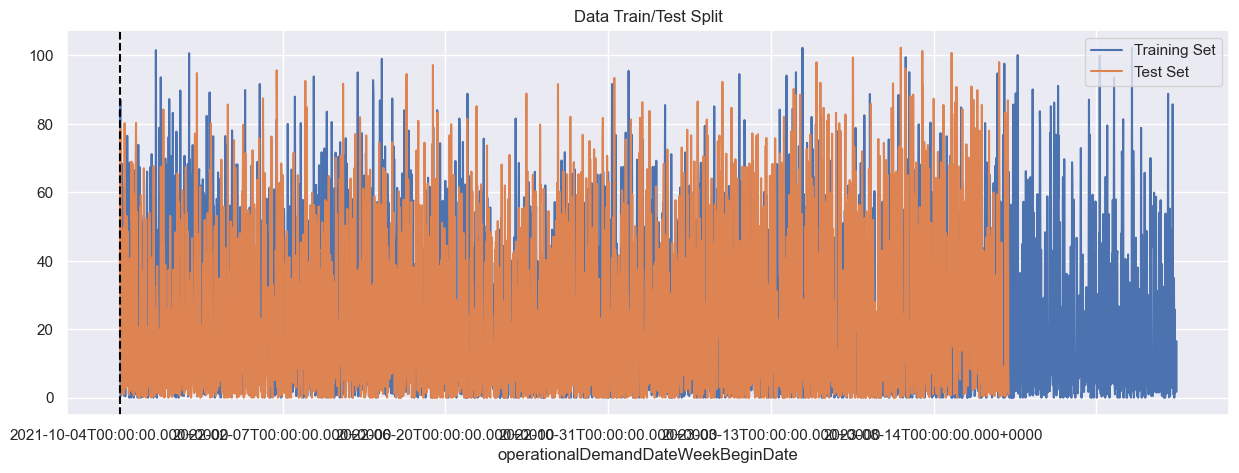

In [62]:
#Filtered data set of train and test split everything before 1st October 2021 trained & everything after tested
train = df.loc[df['operationalDemandDateWeekBeginDate'] < '2021-10-01']
test = df.loc[df['operationalDemandDateWeekBeginDate'] >= '2021-10-01']

#Creation of a new filtered dataframe for train and test splits creates and index for the new df, if not accounted for the plot will include the index 
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

#Creation of plots and subplots to plot train and test sets on different axis 
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(x='operationalDemandDateWeekBeginDate', y='operationalDemandOpHoursSum', ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(x='operationalDemandDateWeekBeginDate', y='operationalDemandOpHoursSum', ax=ax, label='Test Set')
ax.axvline('2021-10-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [23]:
#Looking at the minimum date from when the forecasting data starts
train.min()

operationalDemandDate                          2019-04-01 00:00:00
operationalDemandOrderTypeGroup                                  ?
operationalDemandProcess                                         ?
operationalDemandWorkCentreGroup                               493
operationalDemandOpHoursCount                                    1
operationalDemandOpHoursSum                                    0.0
operationalDemandDateSid                                  20190401
operationalDemandDateWeekBeginDate    2019-04-01T00:00:00.000+0000
operationalDemandSumZeroedRe                                   0.0
operationalDemandOpTravelHours                            0.000278
OperationalDemandYear                                         2019
OperationalDemandMonth                                           1
OperationalDemandDayofweek                                       0
OperationalDemandQuarter                                         1
dtype: object

# Time Series split for a month of data

In [64]:
#Applying time series eda to assess behaviour within a week on data
month1_df = df.loc[(df['operationalDemandDateWeekBeginDate'] >= '2023-04-01') & 
                              (df['operationalDemandDateWeekBeginDate'] < '2023-05-01') &
                              (df['operationalDemandDate'] >=  '2023-04-01') & 
                              (df['operationalDemandDate'] <= '2023-05-01')]

In [65]:
# Sorting the values in the df by the columns in ascending order 
month1_df = month1_df.sort_values(by=['operationalDemandDateWeekBeginDate', 'operationalDemandDate'], ascending=True)

In [66]:
month1_df

,operationalDemandDate,operationalDemandOrderTypeGroup,operationalDemandProcess,operationalDemandWorkCentreGroup,operationalDemandOpHoursCount,operationalDemandOpHoursSum,operationalDemandDateSid,operationalDemandDateWeekBeginDate,operationalDemandSumZeroedRe,operationalDemandOpTravelHours,OperationalDemandYear,OperationalDemandMonth,OperationalDemandDayofweek,OperationalDemandQuarter
411,2023-04-03,PLANNED,COLLECTION,493,4,0.200000,20230403,2023-04-03T00:00:00.000+0000,0.166667,2.350452,2023,4,0,2
507,2023-04-03,PLANNED,MAINTENANCE,493,44,88.530000,20230403,2023-04-03T00:00:00.000+0000,40.833333,20.340621,2023,4,0,2
1844,2023-04-03,REACTIVE,?,493,7,1.750000,20230403,2023-04-03T00:00:00.000+0000,1.083333,2.363769,2023,4,0,2
3483,2023-04-03,REACTIVE,TREATMENT,493,23,33.333333,20230403,2023-04-03T00:00:00.000+0000,13.000000,28.193479,2023,4,0,2
5938,2023-04-03,PLANNED,TREATMENT,493,32,52.716667,20230403,2023-04-03T00:00:00.000+0000,48.666667,18.802442,2023,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,2023-04-28,REACTIVE,?,493,4,2.033333,20230428,2023-04-24T00:00:00.000+0000,4.333333,0.573444,2023,4,4,2
3403,2023-04-28,PLANNED,COLLECTION,493,4,1.866667,20230428,2023-04-24T00:00:00.000+0000,5.200000,1.178282,2023,4,4,2
335,2023-04-29,PLANNED,TREATMENT,493,16,22.846667,20230429,2023-04-24T00:00:00.000+0000,15.500000,11.655332,2023,4,5,2
5324,2023-04-29,REACTIVE,TREATMENT,493,7,15.450000,20230429,2023-04-24T00:00:00.000+0000,4.000000,3.897425,2023,4,5,2


In [67]:
#Line graphs to assess typical trend of operational hours within a week
fig = px.line(month1_df, x='operationalDemandDate', y='operationalDemandOpHoursSum')

#Appropiate axis labelling
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='operationalDemandOpHoursSum')

#title labelling
fig.update_layout(title='Time Series Plot for a month(January 2023)')

fig.show()


# Time series split for a week of data

In [68]:
#Applying time series eda to assess behaviour within a week on data
week1_df = df.loc[(df['operationalDemandDateWeekBeginDate'] >= '2023-04-01') & 
                              (df['operationalDemandDateWeekBeginDate'] < '2023-04-08') &
                              (df['operationalDemandDate'] >=  '2023-04-01') & 
                              (df['operationalDemandDate'] <= '2023-05-01')]

In [69]:
# Sorting the values in the df by the columns in ascending order 
week1_df = week1_df.sort_values(by=['operationalDemandDateWeekBeginDate', 'operationalDemandDate'], ascending=True)

In [70]:
week1_df

,operationalDemandDate,operationalDemandOrderTypeGroup,operationalDemandProcess,operationalDemandWorkCentreGroup,operationalDemandOpHoursCount,operationalDemandOpHoursSum,operationalDemandDateSid,operationalDemandDateWeekBeginDate,operationalDemandSumZeroedRe,operationalDemandOpTravelHours,OperationalDemandYear,OperationalDemandMonth,OperationalDemandDayofweek,OperationalDemandQuarter
411,2023-04-03,PLANNED,COLLECTION,493,4,0.200000,20230403,2023-04-03T00:00:00.000+0000,0.166667,2.350452,2023,4,0,2
507,2023-04-03,PLANNED,MAINTENANCE,493,44,88.530000,20230403,2023-04-03T00:00:00.000+0000,40.833333,20.340621,2023,4,0,2
1844,2023-04-03,REACTIVE,?,493,7,1.750000,20230403,2023-04-03T00:00:00.000+0000,1.083333,2.363769,2023,4,0,2
3483,2023-04-03,REACTIVE,TREATMENT,493,23,33.333333,20230403,2023-04-03T00:00:00.000+0000,13.000000,28.193479,2023,4,0,2
5938,2023-04-03,PLANNED,TREATMENT,493,32,52.716667,20230403,2023-04-03T00:00:00.000+0000,48.666667,18.802442,2023,4,0,2
5962,2023-04-03,REACTIVE,COLLECTION,493,35,61.933333,20230403,2023-04-03T00:00:00.000+0000,39.000000,12.413208,2023,4,0,2
1548,2023-04-04,REACTIVE,COLLECTION,493,29,50.781667,20230404,2023-04-03T00:00:00.000+0000,27.750000,10.052756,2023,4,1,2
2626,2023-04-04,REACTIVE,?,493,9,5.380000,20230404,2023-04-03T00:00:00.000+0000,2.083333,1.743664,2023,4,1,2
3889,2023-04-04,REACTIVE,MAINTENANCE,493,29,58.288333,20230404,2023-04-03T00:00:00.000+0000,24.500000,9.930651,2023,4,1,2
3932,2023-04-04,PLANNED,TREATMENT,493,22,46.431667,20230404,2023-04-03T00:00:00.000+0000,33.583333,17.475100,2023,4,1,2


In [71]:
#Line graphs to assess typical trend of operational hours within a week
fig = px.line(week1_df, x='operationalDemandDate', y='operationalDemandOpHoursSum')

#Appropiate axis labelling
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='operationalDemandOpHoursSum')

#title labelling
fig.update_layout(title='Time Series Plot for a week in January 2023')

fig.show()


# Box Plots for Date Time Analysis

In [32]:
def create_boxplots(column):
    fig = px.box(df, x=column, y='operationalDemandOpHoursSum', title=f'{column} hours')
    fig.show()

In [33]:
# Comparing Operational Demand Year(Comparing how different years perform) against that of operationalDemandOpHoursSum for the EDA 
create_boxplots('OperationalDemandYear')

In [34]:
#assessing monthly variations of operational demand for our eda
create_boxplots('OperationalDemandMonth')

In [35]:
#Daily distribution of operational hours within a week
create_boxplots('OperationalDemandDayofweek')

In [36]:
## Comparing OperationalDemandQuarter(Splitting the year into 4 quarters) against that of operationalDemandOpHoursSum for the EDA 
create_boxplots('OperationalDemandQuarter')

# Weekday Time Series Modelling 

In [37]:
#Filtered data set of train and test split everything before 1st October 2021 trained & everything after tested
week_groupby_train = week_groupby.loc[week_groupby['operationalDemandDateWeekBeginDate'] < '2021-10-01']
week_groupby_test = week_groupby.loc[week_groupby['operationalDemandDateWeekBeginDate'] >= '2021-10-01']

In [38]:
week_groupby_train

,operationalDemandDateWeekBeginDate,operationalDemandOpHoursSum,prev_week_1,prev_week_2,prev_week_3,prev_week_4,OperationalDemandYear,OperationalDemandMonth,OperationalDemandWeek
4,2019-04-29 00:00:00+00:00,648.450000,346.100000,583.566667,501.683333,680.300000,2019,4,18
5,2019-05-06 00:00:00+00:00,524.566667,648.450000,346.100000,583.566667,501.683333,2019,5,19
6,2019-05-13 00:00:00+00:00,702.600000,524.566667,648.450000,346.100000,583.566667,2019,5,20
7,2019-05-20 00:00:00+00:00,599.333333,702.600000,524.566667,648.450000,346.100000,2019,5,21
8,2019-05-27 00:00:00+00:00,627.016667,599.333333,702.600000,524.566667,648.450000,2019,5,22
...,...,...,...,...,...,...,...,...,...
126,2021-08-30 00:00:00+00:00,567.416667,566.935000,508.650000,583.283333,479.501667,2021,8,35
127,2021-09-06 00:00:00+00:00,396.200000,567.416667,566.935000,508.650000,583.283333,2021,9,36
128,2021-09-13 00:00:00+00:00,507.883333,396.200000,567.416667,566.935000,508.650000,2021,9,37
129,2021-09-20 00:00:00+00:00,364.500000,507.883333,396.200000,567.416667,566.935000,2021,9,38


In [39]:
week_groupby_test

,operationalDemandDateWeekBeginDate,operationalDemandOpHoursSum,prev_week_1,prev_week_2,prev_week_3,prev_week_4,OperationalDemandYear,OperationalDemandMonth,OperationalDemandWeek
131,2021-10-04 00:00:00+00:00,673.315000,541.683333,364.500000,507.883333,396.200000,2021,10,40
132,2021-10-11 00:00:00+00:00,624.233333,673.315000,541.683333,364.500000,507.883333,2021,10,41
133,2021-10-18 00:00:00+00:00,379.433333,624.233333,673.315000,541.683333,364.500000,2021,10,42
134,2021-10-25 00:00:00+00:00,528.716667,379.433333,624.233333,673.315000,541.683333,2021,10,43
135,2021-11-01 00:00:00+00:00,386.083333,528.716667,379.433333,624.233333,673.315000,2021,11,44
...,...,...,...,...,...,...,...,...,...
247,2024-01-01 00:00:00+00:00,2.000000,47.683333,2.500000,2.516667,178.045000,2024,1,1
248,2024-01-08 00:00:00+00:00,0.500000,2.000000,47.683333,2.500000,2.516667,2024,1,2
249,2024-01-15 00:00:00+00:00,87.250000,0.500000,2.000000,47.683333,2.500000,2024,1,3
250,2024-01-22 00:00:00+00:00,5.633333,87.250000,0.500000,2.000000,47.683333,2024,1,4


In [40]:
# Features and response variable for week groupby for train set
X_train = week_groupby_train[['OperationalDemandYear', 'OperationalDemandMonth','OperationalDemandWeek','prev_week_1', 'prev_week_2','prev_week_3','prev_week_4']]
y_train = week_groupby_train[['operationalDemandOpHoursSum']]

# # Features and response variable for weekend groupby for train set
X_test = week_groupby_test[['OperationalDemandYear', 'OperationalDemandMonth','OperationalDemandWeek','prev_week_1', 'prev_week_2','prev_week_3','prev_week_4']]
y_test = week_groupby_test[['operationalDemandOpHoursSum']]

In [41]:
# Intitiation of XGB boost model
reg = xgb.XGBRFRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=10, eval_metric = 'mape')


[0]	validation_0-mape:0.10537	validation_1-mape:16.35401


XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=1000, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [42]:
# Creation of a variable outling the most significant features of the Weekday Data frame 
feature_importance = pd.DataFrame(data = reg.feature_importances_,
                                  index= reg.feature_names_in_,
                                  columns = ['importance'])                               

<Axes: title={'center': 'Feature Importance'}>

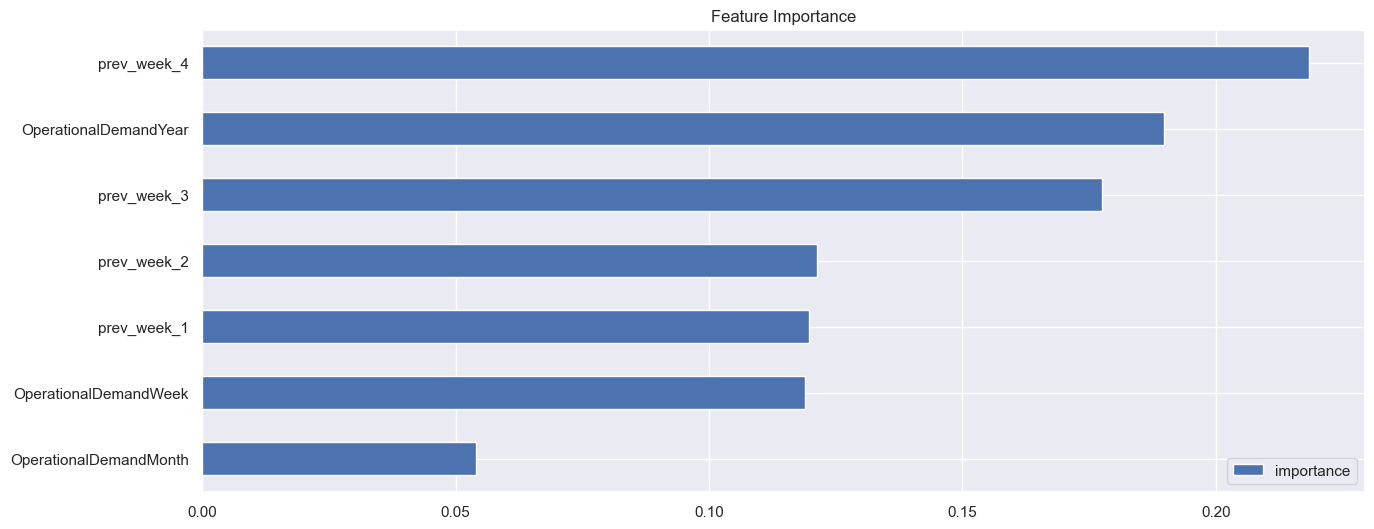

In [43]:
# Visualising the most important features from within the Weekday datatframe 
# For this example, prev_week 2 is the most significant feature 
feature_importance.sort_values('importance').plot(kind= 'barh',title = "Feature Importance")

# Forecasting

In [44]:
# Utilising the model to make predictions on the test set
week_groupby_test['prediction']= reg.predict(X_test)

C:\Users\karth\AppData\Local\Temp\ipykernel_23568\3268557887.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Plots

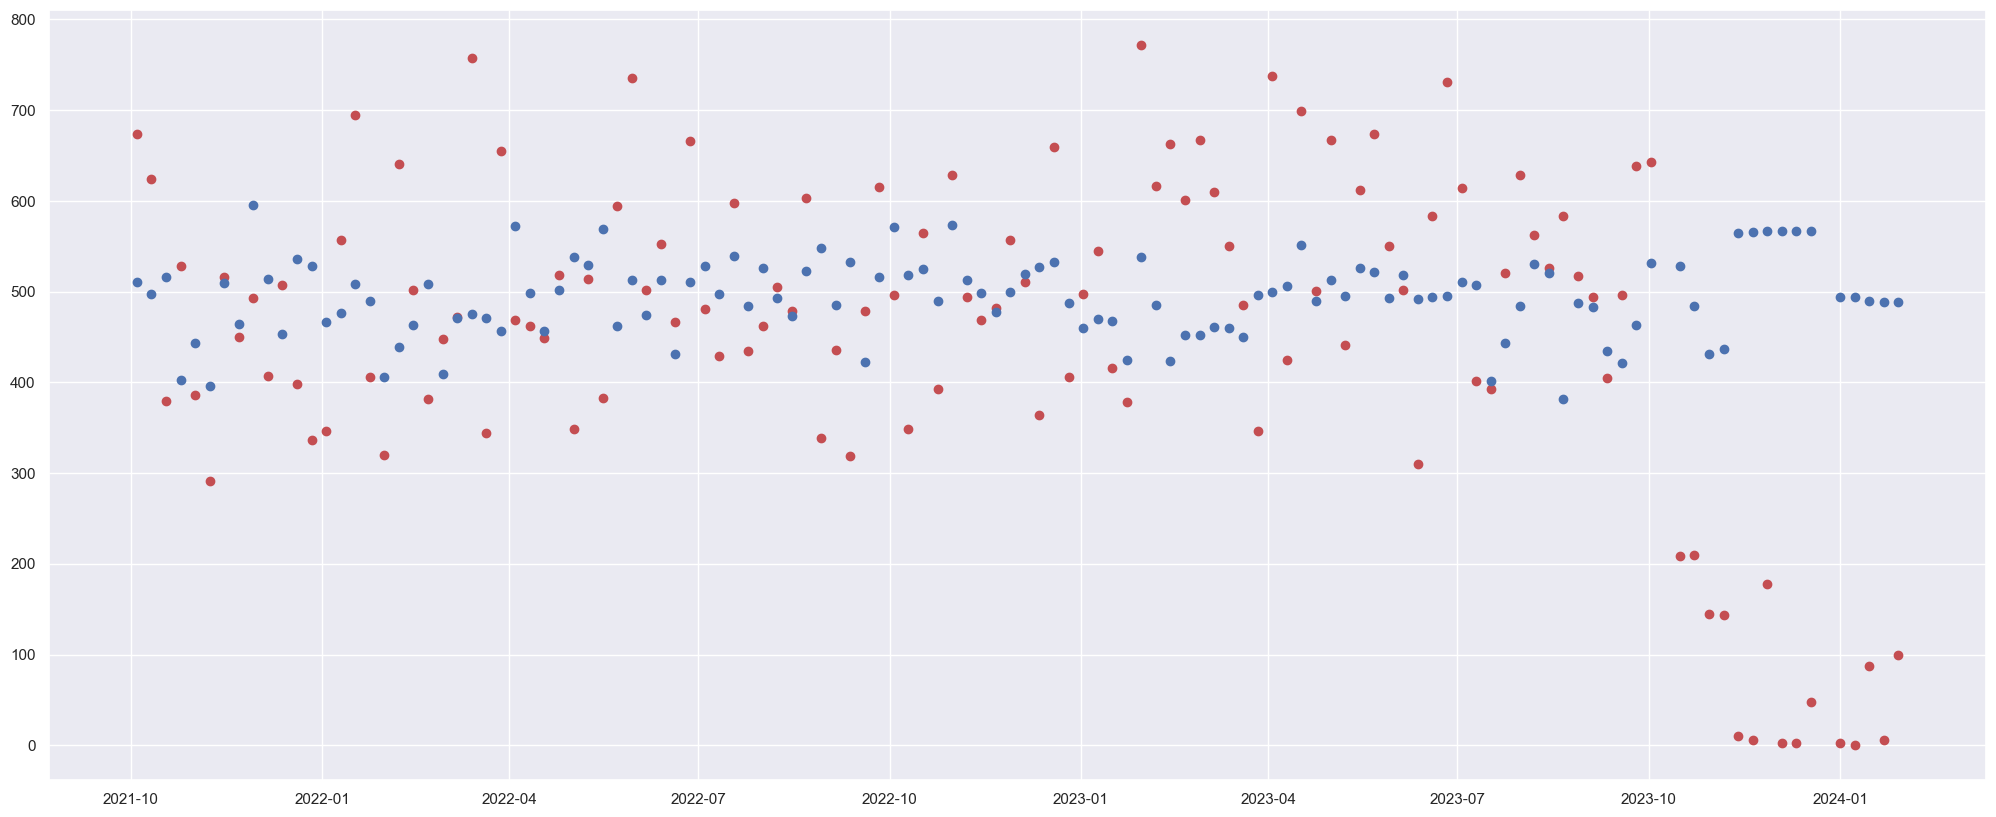

In [45]:
#Actual residuals plotted against the predicition, axis can be misleading when interpretting the prediction
f, ax = plt.subplots(figsize=(25, 10))
ax.scatter(week_groupby_test['operationalDemandDateWeekBeginDate'], week_groupby_test['operationalDemandOpHoursSum'], color='r')
ax.scatter(week_groupby_test['operationalDemandDateWeekBeginDate'], week_groupby_test['prediction'], color='b')

In [46]:
# # Creating a scatter plot which shows the prediction against the actual operationalDemandOpsHoursSum
# sns.scatterplot(week_groupby_test['prediction'], week_groupby_test['operationalDemandOpHoursSum'])
# plt.plot([0, 200], [0, 400])

# Model Evaluation 

In [47]:
# Evaluating the mean squared error 
mse_week = np.sqrt(mean_squared_error(week_groupby_test['operationalDemandOpHoursSum'], week_groupby_test['prediction']))
print("MSE for the week groupby test set: ", mse_week)

MSE for the week groupby test set:  194.65576114127913


In [48]:
# Evaluating the mean absolute error
mae_week = mean_absolute_error(week_groupby_test['operationalDemandOpHoursSum'], week_groupby_test['prediction'])
print("MAE for the week groupby test set: ", mae_week)

MAE for the week groupby test set:  140.09922981092666


# Weekend Time Series Modelling

In [49]:
weekend_groupby

,operationalDemandDateWeekBeginDate,operationalDemandOpHoursSum,prev_week_1,prev_week_2,prev_week_3,prev_week_4,OperationalDemandYear,OperationalDemandMonth,OperationalDemandWeek
4,2019-04-29 00:00:00+00:00,57.300000,38.583333,113.766667,79.333333,90.816667,2019,4,18
5,2019-05-06 00:00:00+00:00,138.316667,57.300000,38.583333,113.766667,79.333333,2019,5,19
6,2019-05-13 00:00:00+00:00,80.016667,138.316667,57.300000,38.583333,113.766667,2019,5,20
7,2019-05-20 00:00:00+00:00,43.333333,80.016667,138.316667,57.300000,38.583333,2019,5,21
8,2019-05-27 00:00:00+00:00,156.600000,43.333333,80.016667,138.316667,57.300000,2019,5,22
...,...,...,...,...,...,...,...,...,...
245,2023-12-18 00:00:00+00:00,11.250000,10.500000,1.250000,6.000000,6.000000,2023,12,51
246,2024-01-01 00:00:00+00:00,1.000000,11.250000,10.500000,1.250000,6.000000,2024,1,1
247,2024-01-08 00:00:00+00:00,1.000000,1.000000,11.250000,10.500000,1.250000,2024,1,2
248,2024-01-22 00:00:00+00:00,4.000000,1.000000,1.000000,11.250000,10.500000,2024,1,4


In [50]:
weekend_groupby.loc[weekend_groupby['operationalDemandDateWeekBeginDate'] >= '2021-10-01']

,operationalDemandDateWeekBeginDate,operationalDemandOpHoursSum,prev_week_1,prev_week_2,prev_week_3,prev_week_4,OperationalDemandYear,OperationalDemandMonth,OperationalDemandWeek
131,2021-10-04 00:00:00+00:00,102.816667,60.800000,54.300000,94.716667,89.266667,2021,10,40
132,2021-10-11 00:00:00+00:00,60.816667,102.816667,60.800000,54.300000,94.716667,2021,10,41
133,2021-10-18 00:00:00+00:00,62.283333,60.816667,102.816667,60.800000,54.300000,2021,10,42
134,2021-10-25 00:00:00+00:00,114.700000,62.283333,60.816667,102.816667,60.800000,2021,10,43
135,2021-11-01 00:00:00+00:00,67.333333,114.700000,62.283333,60.816667,102.816667,2021,11,44
...,...,...,...,...,...,...,...,...,...
245,2023-12-18 00:00:00+00:00,11.250000,10.500000,1.250000,6.000000,6.000000,2023,12,51
246,2024-01-01 00:00:00+00:00,1.000000,11.250000,10.500000,1.250000,6.000000,2024,1,1
247,2024-01-08 00:00:00+00:00,1.000000,1.000000,11.250000,10.500000,1.250000,2024,1,2
248,2024-01-22 00:00:00+00:00,4.000000,1.000000,1.000000,11.250000,10.500000,2024,1,4


In [51]:
#Filtered data set of train and test split everything before 1st October 2021 trained & everything after tested
weekend_groupby_train = weekend_groupby.loc[weekend_groupby['operationalDemandDateWeekBeginDate'] < '2021-10-01']

weekend_groupby_test = weekend_groupby.loc[weekend_groupby['operationalDemandDateWeekBeginDate'] >= '2021-10-01']

In [52]:
# Specifying the columns that need to be inclueded with the X_train_weekend variable 
X_train_weekend = weekend_groupby_train[['OperationalDemandYear', 'OperationalDemandMonth','OperationalDemandWeek','prev_week_1', 'prev_week_2','prev_week_3','prev_week_4']]

# Assigning the column from the original dataframe that needs to be assigned  as y_train_weekend
y_train_weekend = weekend_groupby_train[['operationalDemandOpHoursSum']]

# Specifying the columns that need to be included within the X_test_weekend and assigning it the variable of the same name
X_test_weekend = weekend_groupby_test[['OperationalDemandYear', 'OperationalDemandMonth','OperationalDemandWeek','prev_week_1', 'prev_week_2','prev_week_3','prev_week_4']]

# Assignin the column from the original dataframe that needs to be assigned to the variable y_test_weekend
y_test_weekend = weekend_groupby_test[['operationalDemandOpHoursSum']]

In [53]:
# Applying the XGB Regressor for the weekend calcauting MAPE values
reg_weekend = xgb.XGBRFRegressor(n_estimators=1000)
reg_weekend.fit(X_train_weekend, y_train_weekend,
                eval_set=[(X_train_weekend, y_train_weekend), (X_test_weekend, y_test_weekend)],
                verbose=10, eval_metric = 'mape')

[0]	validation_0-mape:0.25072	validation_1-mape:6.33156


XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=1000, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [54]:
# Creation of a feature importance variable which will outline the features with the most significan in this dataframe
feature_importance_weekend = pd.DataFrame(data = reg_weekend.feature_importances_,
                                          index= reg_weekend.feature_names_in_,
                                          columns = ['importance'])      

<Axes: title={'center': 'Feature Importance'}>

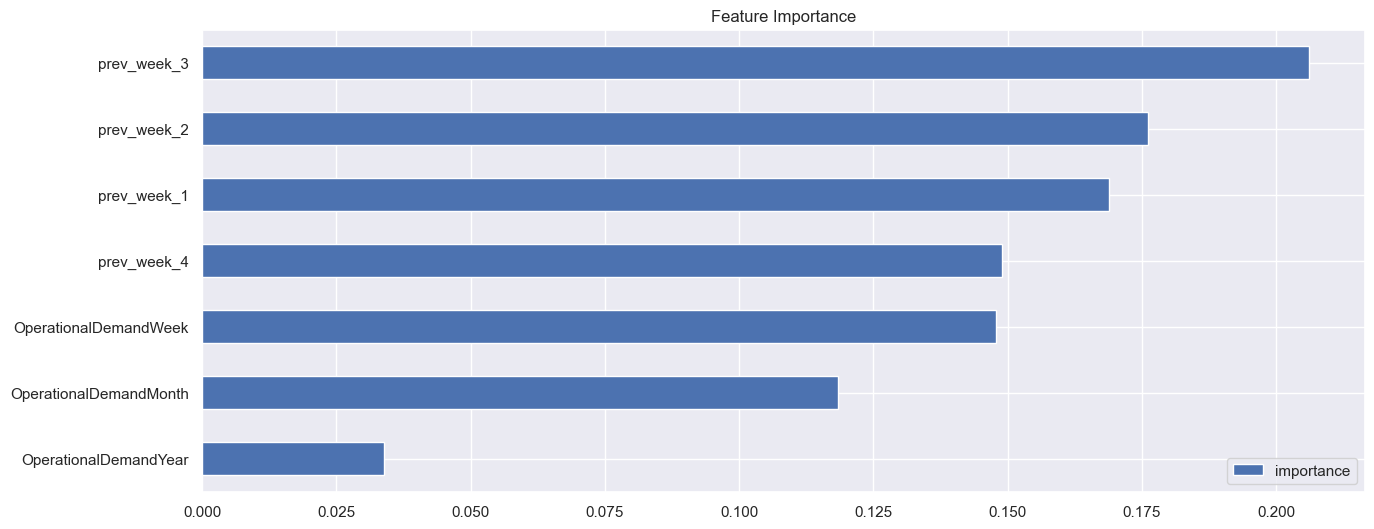

In [55]:
# Calculating the feature importance for Weekend
# From here we can see that data from the previous 2 weeks is the most significant 
feature_importance_weekend.sort_values('importance').plot(kind= 'barh',title = "Feature Importance")

In [56]:
# Applying the model
weekend_groupby_test['prediction']= reg_weekend.predict(X_test_weekend)

C:\Users\karth\AppData\Local\Temp\ipykernel_23568\3367861097.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
weekend_groupby_test

,operationalDemandDateWeekBeginDate,operationalDemandOpHoursSum,prev_week_1,prev_week_2,prev_week_3,prev_week_4,OperationalDemandYear,OperationalDemandMonth,OperationalDemandWeek,prediction
131,2021-10-04 00:00:00+00:00,102.816667,60.800000,54.300000,94.716667,89.266667,2021,10,40,89.585518
132,2021-10-11 00:00:00+00:00,60.816667,102.816667,60.800000,54.300000,94.716667,2021,10,41,108.756653
133,2021-10-18 00:00:00+00:00,62.283333,60.816667,102.816667,60.800000,54.300000,2021,10,42,100.425552
134,2021-10-25 00:00:00+00:00,114.700000,62.283333,60.816667,102.816667,60.800000,2021,10,43,85.567459
135,2021-11-01 00:00:00+00:00,67.333333,114.700000,62.283333,60.816667,102.816667,2021,11,44,108.220009
...,...,...,...,...,...,...,...,...,...,...
245,2023-12-18 00:00:00+00:00,11.250000,10.500000,1.250000,6.000000,6.000000,2023,12,51,129.045715
246,2024-01-01 00:00:00+00:00,1.000000,11.250000,10.500000,1.250000,6.000000,2024,1,1,140.342926
247,2024-01-08 00:00:00+00:00,1.000000,1.000000,11.250000,10.500000,1.250000,2024,1,2,140.733093
248,2024-01-22 00:00:00+00:00,4.000000,1.000000,1.000000,11.250000,10.500000,2024,1,4,141.149948


# Weekend Visuals

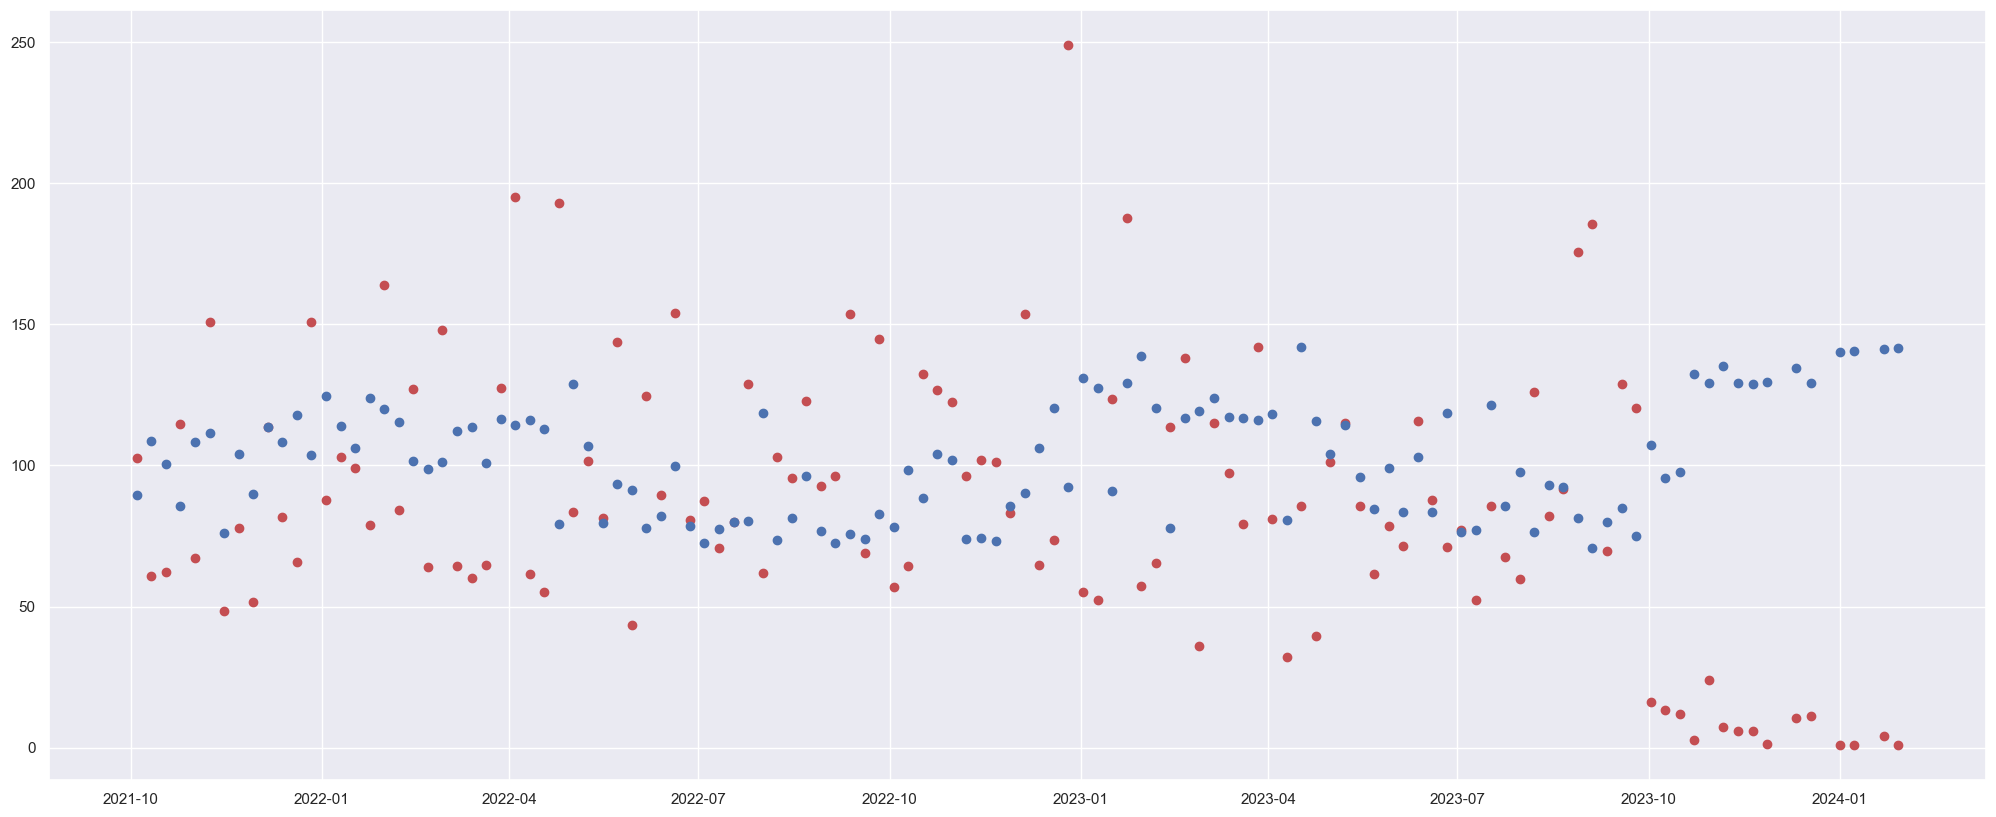

In [58]:
#Actual residuals plotted against the predicition, axis can be misleading when interpretting the prediction
f, ax = plt.subplots(figsize=(25, 10))
ax.scatter(weekend_groupby_test['operationalDemandDateWeekBeginDate'], weekend_groupby_test['operationalDemandOpHoursSum'], color='r')
ax.scatter(weekend_groupby_test['operationalDemandDateWeekBeginDate'], weekend_groupby_test['prediction'], color='b')

In [59]:
# # Scatter plot on the Weekened Groupbyplotting the prediction against OperationDemand OPs Hours
# sns.scatterplot(weekend_groupby_test['prediction'], weekend_groupby_test['operationalDemandOpHoursSum'])
# plt.plot([0, 100], [0, 100])

In [60]:
# Calcaulting the mean squared error
mse_weekend = np.sqrt(mean_squared_error(weekend_groupby_test['operationalDemandOpHoursSum'], weekend_groupby_test['prediction']))
print("Mean Squared Error for Weekend: ", mse_weekend)

Mean Squared Error for Weekend:  60.45354336254462


In [61]:
# Evaluating the mean absolute error
mae_week = mean_absolute_error(weekend_groupby_test['operationalDemandOpHoursSum'], weekend_groupby_test['prediction'])
print("MAE for the week groupby test set: ", mae_week)

MAE for the week groupby test set:  46.945032906839494
